## PyCPTv1.2 -- 30 March 2019
## Produce S2S (un)calibrated forecasts and assess associated skill 
## ECMWF/CFSv2/GEFS-TRMM version

#### Authors: 
Ángel G. Muñoz (agmunoz@iri.columbia.edu) and Andrew W. Robertson (awr@iri.columbia.edu) 

#### Acknowledgements: 
Rémi Cousin (key Ingrid code), James Doss-Gollin (key Python functions).
Part of the effort to develop PyCPT is funded by the Columbia World Project "Adapting Agriculture to Climate Today, for Tomorrow" (ACToday), and NOAA MAPP's projects NA18OAR4310275 (Muñoz) and NA16OAR4310145 (Robertson). 

#### Version log
* 30 Mar 2019, AGM: added PCR option, CHIRPS as obs, flexible format plots, automatically uses retrospective for validation (due to the very high sample size). Solved problems related to masking missing values. ELR still has some problems (values are different from our R or Matlab codes -- working on it, so not included in this version).
* 25 Aug 2018, AGM: added CPC Unified data as obs, plots are now raster maps, fixed field shift due to sequential grads format in CPT, automatic colobar limits and field name for deterministic forecast
* 24 Aug 2018, AWR: IMD data version (not public).
* 23 Aug 2018, AWR: GEFS SubX model added.
* 15 Aug 2018, AGM: Plotting capabilities added.
* PyCPTv1.1:ECMWF/CFSv2-TRMM, modified by AGM on 1 Aug 2018
* Previous version: 17 Jul 2018, modified by AWR
* First iPython version (Jupyter Notebook) by AWR -- 24 Jun 2018
* First version (BASH) by AGM -- 12 Dec 2017 

#### Input:
* Predictor is rainfall from S2S ECMWF (no realtime), or NCEP CFSv2 (realtime), or SubX GEFS (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7) or CPC Unified or IMD

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.

#### Notes:
1. Old data in the input folder is deleted at the beginning of the process!
2. Initializations available per month are used, concatenated.
3. The T coordinate has been faked, so CPT can deal with all the initializations.

### Namelist section

In [1]:
########Model (choose between ECMWF, CFSv2, GEFS)
model='ECMWF'

########Obs (choose between CHIRPS, TRMM, CPC, IMD1deg, IMDp25deg)
obs='CHIRPS'

########MOS method (choose between None, PCR, CCA and ELR)
MOS='CCA'

########Forecast date  
##-- If ECMWF, it needs to be a Monday or a Thursday! CFSv2: any day; GEFS: Wednesdays.
mon='Feb' 	# Forecast month 
fyr=2019 	# Forecast year
fday=14 	# Forecast day  (Yesterday in CFSv2: real time)
training_season='Feb-Apr' #for CFSv2 and GEFS, use 3 months with the initialization as the middle one

nwk=4 # Number of weeks to process (leads)

########Switches:
force_download = False   #force download of data files, even if they already exist locally
# Rainfall frequency switch 
rainfall_frequency = False  #False gives total rainfall for forecast period

wetday_threshold = 3 #WET day threshold (mm) --only used if rainfall_frequency is True!
threshold_pctle = False    #False for threshold in mm; Note that if True then if counts DRY days!!!

########Spatial domain for predictor
nla1=35 	# Northernmost latitude
sla1=-20 	# Southernmost latitude
wlo1=73 	# Westernmost longitude
elo1=155 	# Easternmost longitude
# Spatial domain for predictand
nla2=30 	# Northernmost latitude
sla2=-15 	# Southernmost latitude
wlo2=78 	# Westernmost longitude
elo2=150 	# Easternmost longitude

########Forecast lead interval
# Lists for looping over lead times
wk = [1,2,3,4,34]  # week-lead number label (week1, week2, week3-4)
# ECMWF - first day is day 0, 0000Z accumulated rainfall; specify day1=0 for week 1
# GEFS - first day is day 0.5 (daily average rainfall rate); specify day1=0 for week 1
# CFSv2 - first day is day 1, 0000Z accumulated rainfall ovder the first day; specify day1=1 for week 1 
day1 = [0,7,14,21,14]  # first lead day of target weeks 
day2 = [7,14,21,28,28]  # last lead day of target weeks 
# 
wknam= ['Week 1','Week 2','Week 3','Week 4','Week 3-4']  #naming the weeks (for plots)

In [2]:
########Some folder and file options:
# Working directory --it should exist!!!
workdir = '/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/'
#workdir = '/Users/andy/Dropbox/Projects/IRAP/India-IRAP/S2Dposter'
# PATH to CPT root directory
cptdir='/Users/agmunoz/Documents/Angel/CPT/CPT/15.7.8/'
#cptdir='/Users/andy/Dropbox/pgm/stats/CPT/CPT15/15.7.8/'

########Naming of output files
if rainfall_frequency:
    fprefix = 'RFREQ'
else:
    fprefix = 'PRCP'

########Model-dependent parameters
if model=='CFSv2':
    hstep = 3 # use all starts in the trainng period with this daily step between them (v5 used 7)
    nlag  = 3  # length of the lagged ensemble in days
    ntrain= 371  # Length of training period
elif model=='ECMWF':
    hstep = 0 # bogus but needed by functions (eliminate in the future)
    nlag  = 0 # bogus but needed by functions (eliminate in the future)
    ntrain= 160  # Length of training period
elif model=='GEFS':
    hstep = 0 # bogus but needed by functions (eliminate in the future)
    nlag  = 0 # bogus but needed by functions (eliminate in the future)
    ntrain= 226  # Length of training period (for JJA, 1999-2015)   
else:
    print ("Model option is invalid")
    
########Observation dataset URLs
if obs == 'TRMM':
    obs_source = 'SOURCES/.NASA/.GES-DAAC/.TRMM_L3/.TRMM_3B42/.v7/.daily/.precipitation/X/0./1.5/360./GRID/Y/-50/1.5/50/GRID'
    hdate_last = 2014
elif obs == 'CPC':
    obs_source = 'SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/X/0./1.5/360./GRID/Y/-90/1.5/90/GRID'
    hdate_last = 2018
elif obs == 'CHIRPS':
    obs_source = 'SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/X/0./1.5/360./GRID/Y/-90/1.5/90/GRID'
    hdate_last = 2018
elif obs == 'IMD1deg':
    obs_source = 'SOURCES/.IMD/.NCC1-2005/.v4p0/.rf'
    hdate_last = 2015
elif obs == 'IMDp25deg':
    obs_source = 'SOURCES/.IMD/.RF0p25/.gridded/.daily/.v1901-2015/.rf'
    hdate_last = 2016
else:
    print ("Obs option is invalid")
    
########MOS-dependent parameters
if MOS=='None':
    mpref='noMOS'
elif MOS=='CCA':
    mpref='CCA'
elif MOS=='PCR':
    mpref='PCR'
elif MOS=='ELR':
    mpref='ELRho'
else:
    print ("MOS option is invalid")

# S2S Database key
print("Present folder is:")
%cd $workdir
with open('.IRIDLAUTH') as file:
    authkey = file.read() 

Present folder is:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT


### End of namelist section  (do not modify anything below this line)

#### Load Libraries

In [3]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
from pycpt_functions import *
from scipy.stats import t
if MOS=='ELR':
    from sklearn.linear_model import LogisticRegression
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar

In [4]:
if rainfall_frequency:
    print('Predictand is Rainfall Frequency; wet day threshold = '+str(wetday_threshold)+' mm')
else:
    print('Predictand is Rainfall Total (mm)')
    
print("Creating working folders, if not already there...")
print("Work directory is:")
%cd $workdir
!mkdir -p input
!mkdir -p output
!mkdir -p scripts
!rm -Rf scripts/*

# Set up CPT environment
os.environ["CPT_BIN_DIR"] = cptdir
print("CPT environment loaded...")

Predictand is Rainfall Total (mm)
Creating working folders, if not already there...
Work directory is:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT
CPT environment loaded...


## Check if domains are ok --if you don't like them, go back to the namelist and modify them

Forecast date is 14 Feb 2019

   February 2019
Mo Tu We Th Fr Sa Su
             1  2  3
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
18 19 20 21 22 23 24
25 26 27 28

     March 2019
Mo Tu We Th Fr Sa Su
             1  2  3
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
18 19 20 21 22 23 24
25 26 27 28 29 30 31



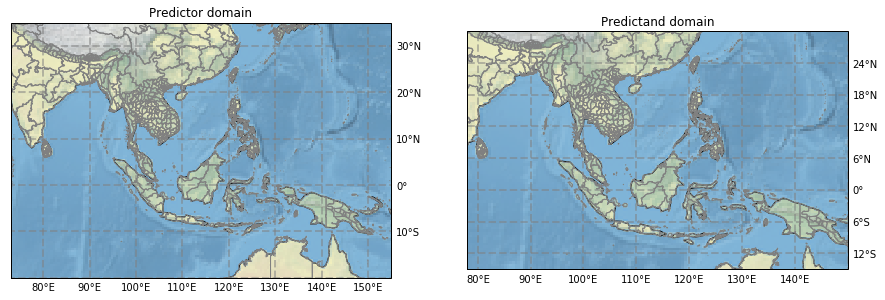

In [5]:
#Print calendars
print('Forecast date is '+str(fday)+' '+mon+' '+str(fyr))
print('')
c=calendar.TextCalendar(calendar.MONDAY)
print(c.formatmonth(fyr,list(calendar.month_abbr).index(mon)))
if list(calendar.month_abbr).index(mon)+1==13:
    print(c.formatmonth(fyr+1,1))
else:
    print(c.formatmonth(fyr,list(calendar.month_abbr).index(mon)+1))

#Plot domains
pltdomain(wlo1,elo1,nla1,sla1,wlo2,elo2,nla2,sla2)

# Download data if necessary, and run CPT

In [5]:
for L in range(nwk):
   nday=day2[L]-day1[L]	# Length of target period (days) 
   print("New folder:")
   %cd $workdir/input

   PrepFiles(rainfall_frequency,threshold_pctle, wlo1, wlo2,elo1, elo2,sla1, sla2,nla1, nla2, day1[L], day2[L], fday, nday, fyr, mon, os, authkey, wk[L], wetday_threshold, nlag, training_season, hstep, model, obs_source, hdate_last, force_download)
 
   print("New folder:")
   %cd $workdir/scripts

   CPTscript(mon,fday,wk[L],nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,training_season,ntrain,rainfall_frequency,MOS)

   print('Executing CPT for Week '+str(wk[L])+'... This might take a while...')
   os.system(cptdir+'CPT.x < params > CPT_stout_train_'+training_season+'_'+mon+'_'+str(fday)+'_wk'+str(wk[L])+'.txt')
   print('----------------------------------------------')
   print('Week '+str(wk[L])+' calculations completed!')
   print('See output folder, and check scripts/CPT_stout_train_'+training_season+'_'+mon+'_'+str(fday)+'_wk'+str(wk[L])+'.txt for errors')
   print('----------------------------------------------')
   print('----------------------------------------------')



New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/input
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/scripts
MOS option is invalid
Executing CPT for Week 1... This might take a while...
----------------------------------------------
Week 1 calculations completed!
See output folder, and check scripts/CPT_stout_train_Feb-Apr_Feb_14_wk1.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/input
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
-----------------

## Skill maps

New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/output


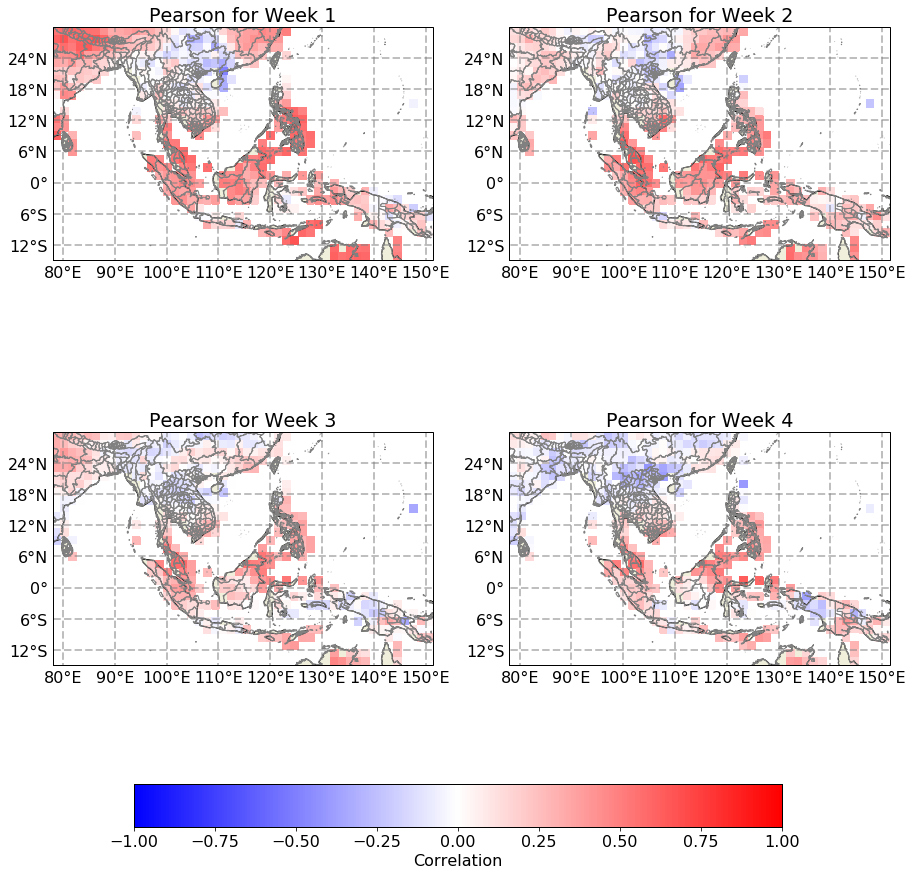

----------------------------------------------



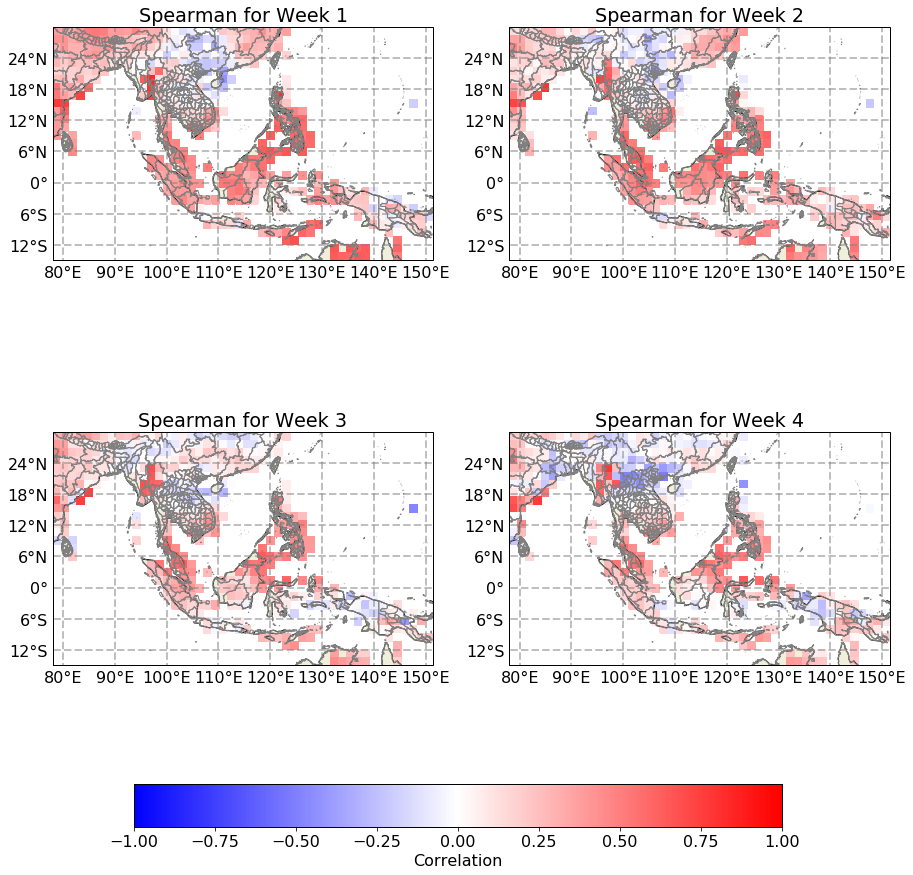

----------------------------------------------



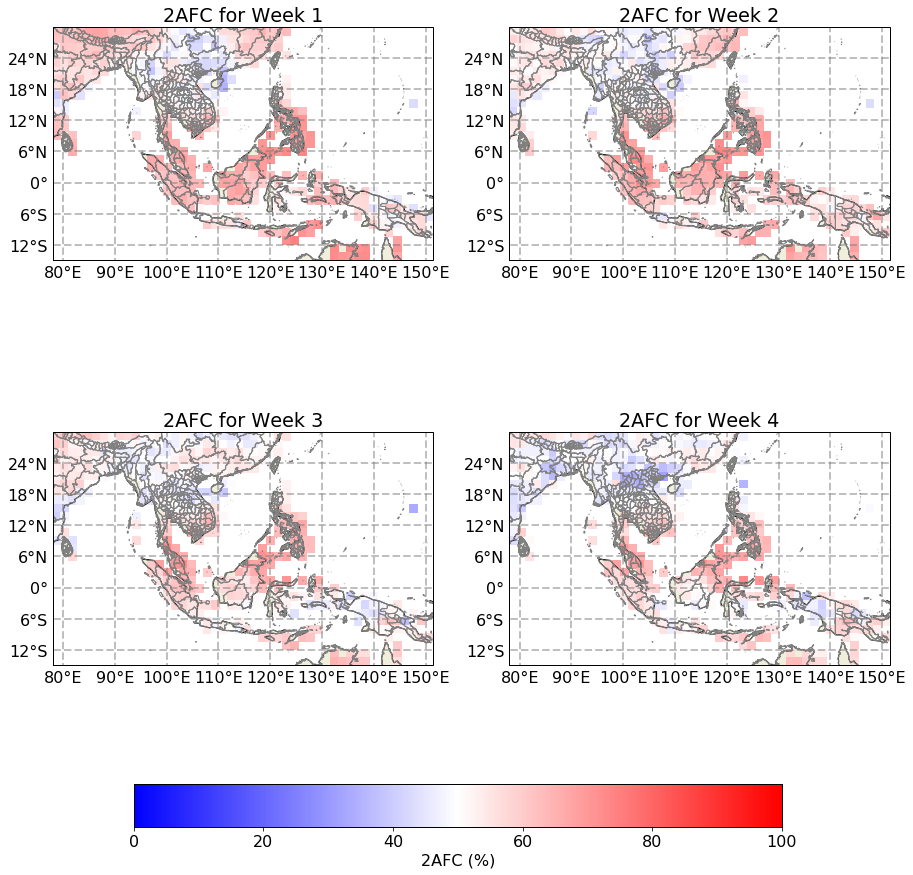

----------------------------------------------



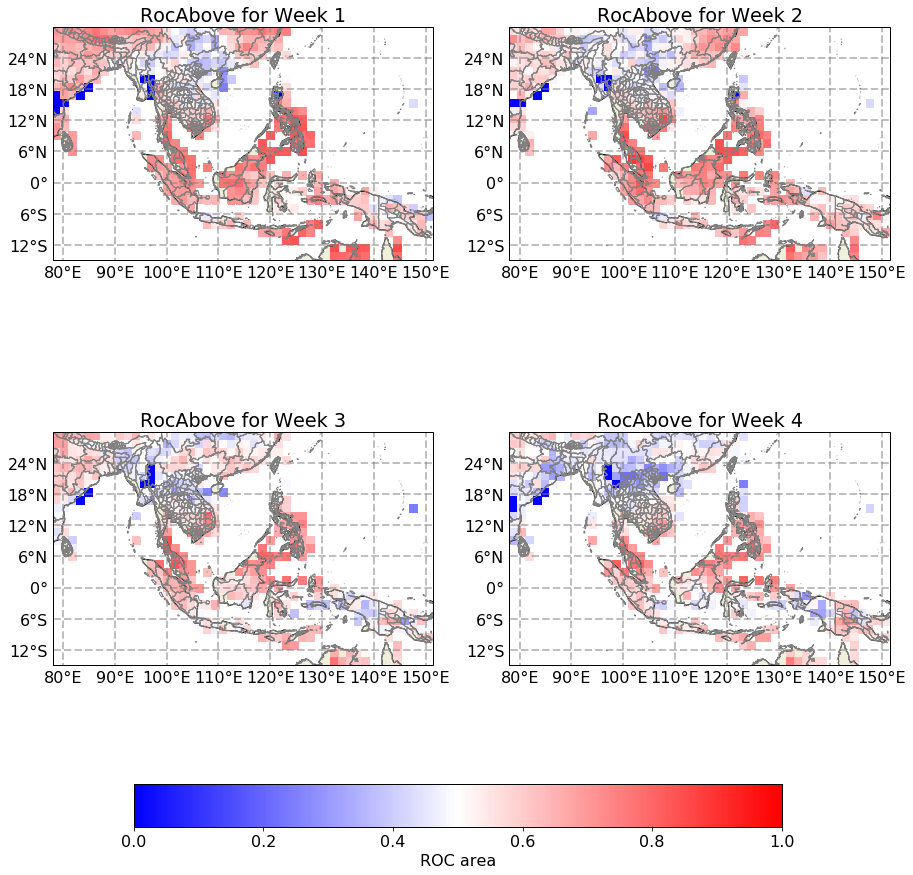

----------------------------------------------



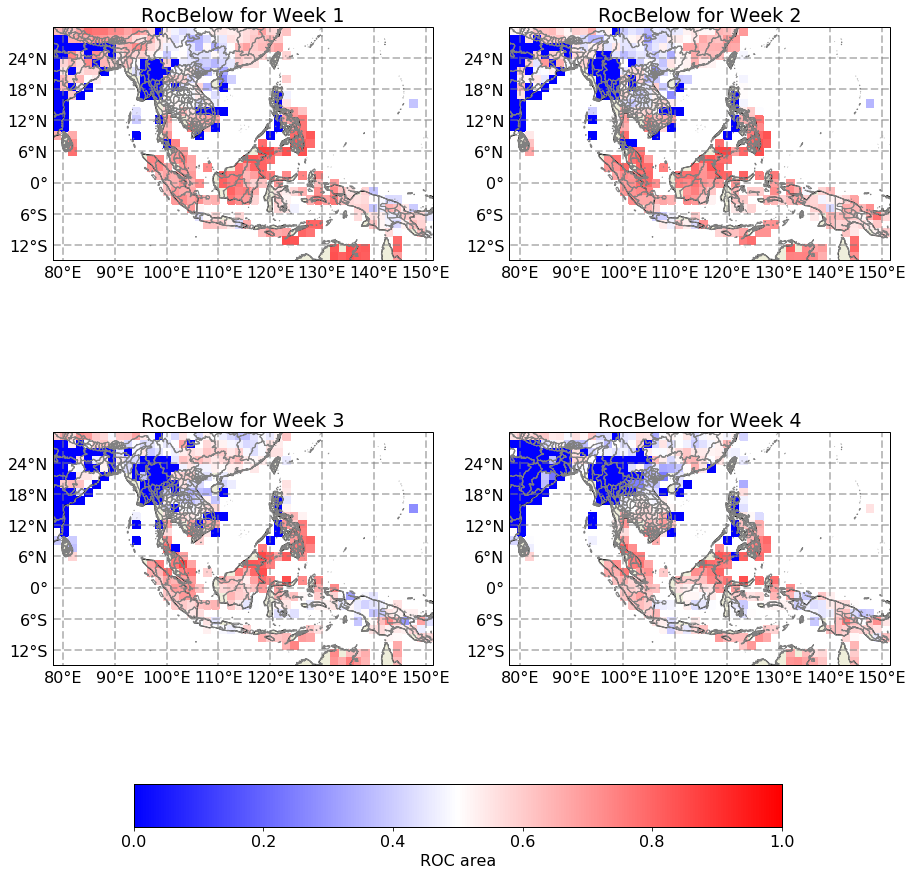

----------------------------------------------



In [5]:
print("New folder:")
%cd $workdir/output

# Skill scores loop
plt.rcParams.update({'font.size': 14})
for ime in ('Pearson','Spearman','2AFC','RocAbove','RocBelow'):
    pltmap(ime,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season, mon, fday, nwk)   
    plt.show()
    print('----------------------------------------------')
    print('')

## Forecast maps

Folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/output
----------------------------------------------



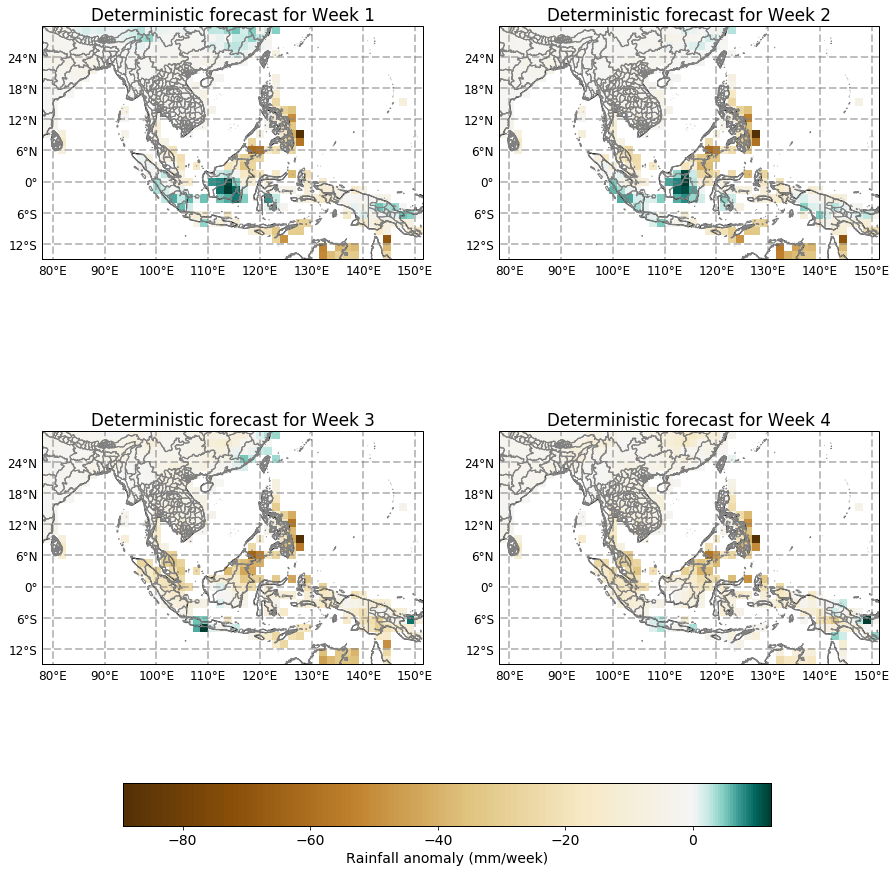

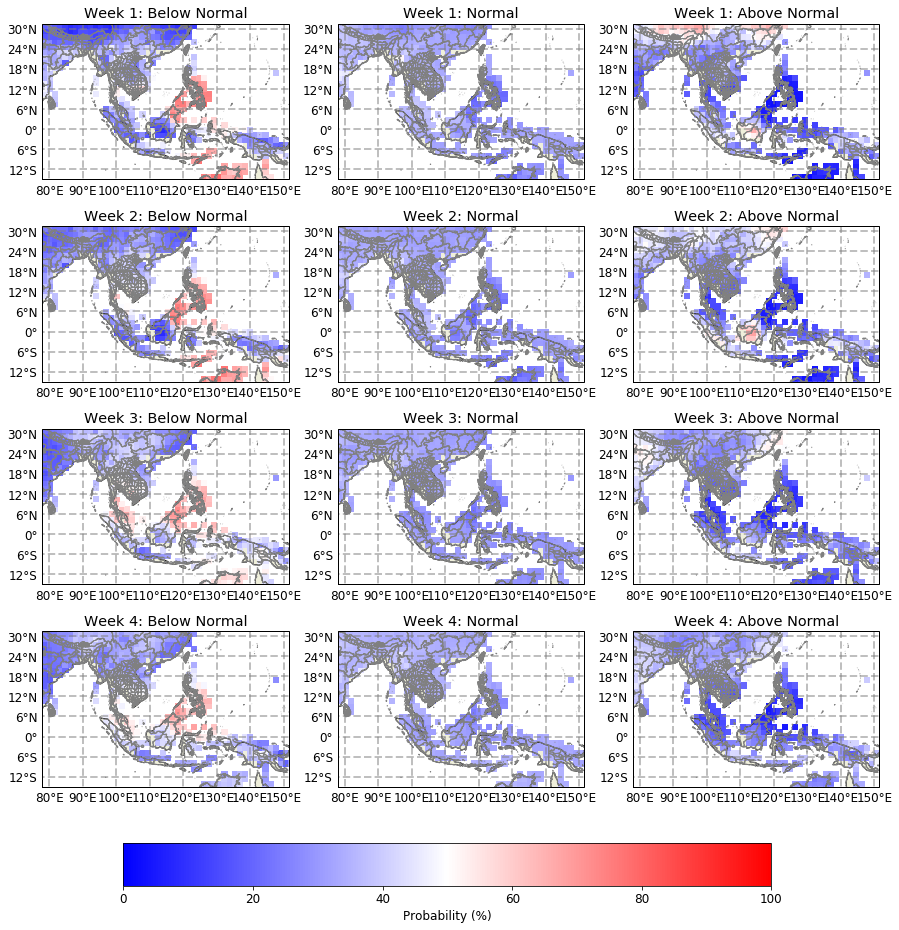

In [5]:
print("Folder:")
%cd $workdir/output

plt.rcParams.update({'font.size': 14})
pltmap(mpref+'FCST_V',wlo2,elo2,sla2,nla2,fprefix,mpref,training_season, mon, fday, nwk)
print('----------------------------------------------')
print('')
plt.rcParams.update({'font.size': 12})
pltmapProb(wlo2,elo2,sla2,nla2,fprefix,mpref,training_season, mon, fday, nwk)
plt.savefig("ProbFcst.pdf", dpi=300)

### Predictions in Flexible Format

Folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/output


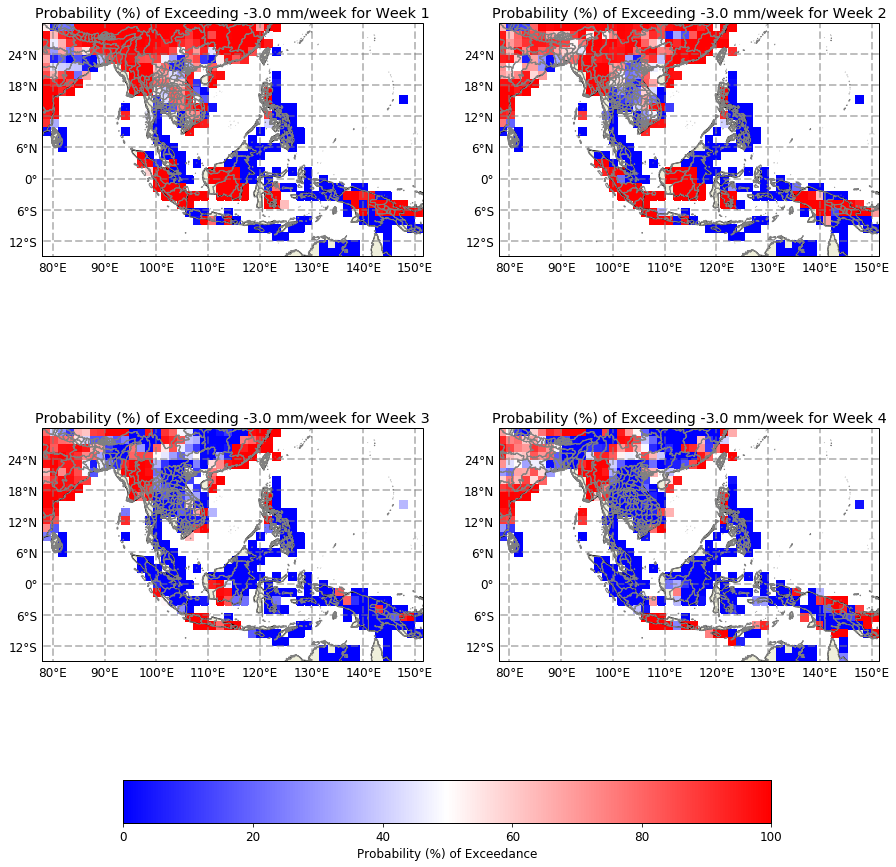

In [5]:
flexformat_threshold = -3. #threshold for the flexible format map (in mm/week -- remember fcst is in ANOMALIES!)

print("Folder:")
%cd $workdir/output
plt.rcParams.update({'font.size': 12})
pltmapff(flexformat_threshold,ntrain,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season,mon,fday,nwk)
plt.savefig("ProbFcst_Flex.pdf", dpi=300)

<Figure size 1080x1080 with 0 Axes>

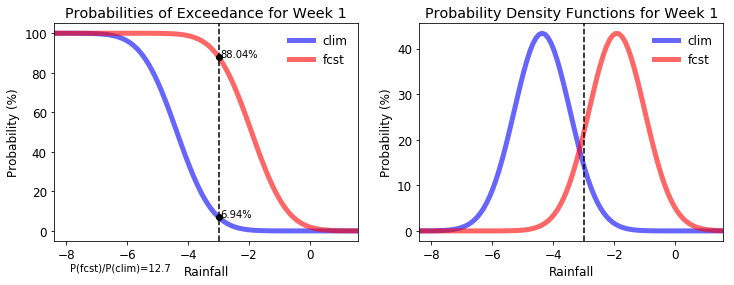

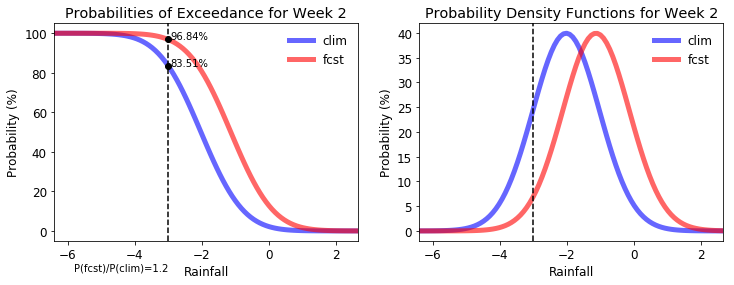

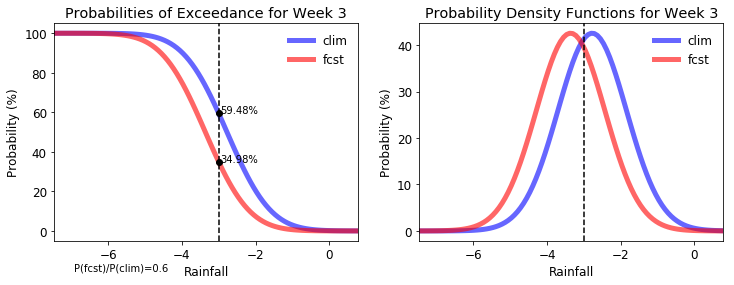

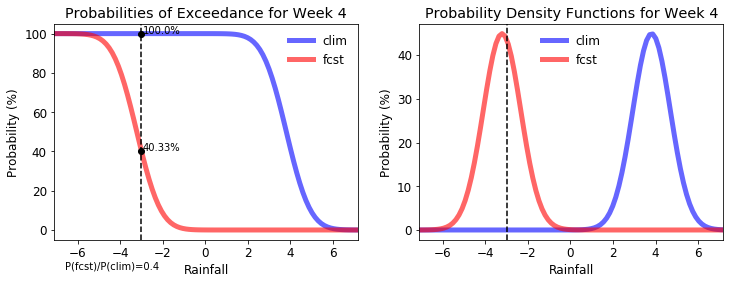

In [6]:
#flexformat_threshold = 0.3 #threshold for the flexible format map (in mm/week)
lon=100
lat=24

plt.rcParams.update({'font.size': 12})
pltprobff(flexformat_threshold,ntrain,lon,lat,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season,mon,fday,nwk)
plt.savefig("ProbExceed.pdf", dpi=300)